In [ ]:
# ENV["CONDA_ENV"]="conda_jl"
# ENV["CONDA_JL_HOME"]="$(ENV["HOME"])/.conda/envs/$(ENV["CONDA_ENV"])"
# ENV["PYTHON"]="$(ENV["CONDA_JL_HOME"])/bin/python"

In [9]:
using DrWatson
@quickactivate "TriangularHubbard"
using TriangularHubbard

using PyCall
using PyPlot

using LinearAlgebra
using JSON
using DBInterface
using SQLite
using DataFrames
using DataFramesMeta
using LsqFit
using Printf
using Quadmath
using ProgressMeter
using Dates
mpl = pyimport("matplotlib")
sns = pyimport("seaborn")

backend_pdf = pyimport("matplotlib.backends.backend_pdf")

  Activating project at `/gpfs/research/changlani/Lee_project/TriangularHubbard`


PyObject <module 'matplotlib.backends.backend_pdf' from '/gpfs/home/kyungminlee_42/.conda/envs/conda_jl/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py'>

In [10]:
shape_str = "(3,0)x(0,3)"

"(3,0)x(0,3)"

# 1. Read Lattice Data

In [11]:
jsondata = open(datadir("lattice-$shape_str.json"), "r") do f
    JSON.parse(read(f, String))
end

shape = hcat(jsondata["shape"]...)
n_sites = Int(det(shape))
bravaiscoordinates = hcat(jsondata["bravais_coordinates"]...)
reciprocallatticevectors = hcat(jsondata["unitcell"]["reciprocallatticevectors"]...)
sitecoordinates = hcat((x["cartesian_coordinates"] for x in jsondata["supercell"]["sites"])...)
momentums = hcat((x["cartesian_coordinates"] for x in jsondata["momentums"])...)
fractionalmomentums = hcat(([eval(Meta.parse(y)) for y in x["fractional_coordinates"]] for x in jsondata["momentums"])...)
sitegroupmap = Dict()
for (i, vs) in enumerate(jsondata["equivalent_site_pairs"])
    for v in vs
        sitegroupmap[v] = i
    end
end
phases = cis.(-2π * momentums' * sitecoordinates)
n_sitegroup = maximum(values(sitegroupmap))

3

In [12]:
p0 = [4π/3, 0]
R = [cos(π/3) -sin(π/3); sin(π/3) cos(π/3)]
zone_boundary = [p0]
p = p0
for i in 1:5
    p = R * p
    push!(zone_boundary, p)
end
push!(zone_boundary, p0)
zone_boundary = hcat(zone_boundary...);

In [13]:
function getrealspacemap(data::AbstractVector)
    realspacemap = fill(NaN, n_sites)
    @assert length(data) == n_sitegroup
    for i in 1:n_sites
        realspacemap[i] = data[sitegroupmap[[1,i]]]
    end
    return realspacemap
end

getrealspacemap (generic function with 1 method)

In [14]:
realspacemap_test = ones(Float64, (n_sites, 1))
abs2.(phases * realspacemap_test)

9×1 Matrix{Float64}:
 81.0
  4.782469237902384e-30
  1.8797076257219422e-29
  8.874685183736383e-31
  2.0954117794933126e-31
  2.297557386456197e-29
  4.992010415851715e-30
  1.1093356479670479e-29
  1.232595164407831e-30

In [17]:
# fig = PyPlot.figure(figsize=(5,3))
# ax = fig.add_subplot(1,2,1)
# ax.plot(2π * momentums[1,:], 2π * momentums[2,:], "o", markersize=12)
# for i in 1:size(momentums, 2)
#     ax.text(2π * momentums[1,i], 2π * momentums[2,i], "$i", ha="center", va="center", color="w")
# end
# ax.set_aspect(1.0)
# ax.plot(zone_boundary[1,:], zone_boundary[2,:], "r-")


# ax = fig.add_subplot(1,2,2)
# ax.plot(sitecoordinates[1,:], sitecoordinates[2,:], "o")
# ax.set_aspect(1.0)

# 2. Read ED Data

In [57]:
# conn = DBInterface.connect(SQLite.DB, datadir("curie", shape_str, "sectors.sqlite3"))
# df = DataFrame(DBInterface.execute(conn, """
#         SELECT
#           sectors.idx, nup, ndn, tii, pii, pic, dim, 
#           hopping, interaction, temperature,
#           base_energy, partition, energy, energy_squared, correlation, 'dense' as type
#         FROM dense_results
#         JOIN sectors USING(idx)
#         JOIN dense_energy_shifts USING(idx, hopping, interaction)
        

#         UNION
        
#         SELECT
#           sectors.idx, nup, ndn, tii, pii, pic, dim, 
#           hopping, interaction, temperature,
#           base_energy, partition, energy, energy_squared, correlation, 'sparse' as type
#         FROM sparse_results
#         JOIN sectors USING(idx)
#         JOIN sparse_energy_shifts USING(idx, hopping, interaction)
#         ;        
#     """))
# close(conn)

In [59]:
conn = DBInterface.connect(SQLite.DB, datadir("curie", shape_str, "sectors.sqlite3"))

dff = DataFrame(DBInterface.execute(conn, """
        SELECT 
          sectors.idx, nup, ndn, tii, pii, pic, dim, 
          hopping, interaction, temperature,
          S2.base_energy AS sparse_base_energy,
          S.partition AS sparse_partition,
          S.energy AS sparse_energy,
          S.energy_squared AS sparse_energy_squared,
          S.correlation AS sparse_correlation,
          
          D2.base_energy AS dense_base_energy,
          D.partition AS dense_partition,
          D.energy AS dense_energy,
          D.energy_squared AS dense_energy_squared,
          D.correlation AS dense_correlation
        
        FROM sparse_results AS S
        JOIN sparse_energy_shifts AS S2 USING(idx, hopping, interaction)

        INNER JOIN dense_results AS D USING (idx, hopping, interaction, temperature)
        JOIN dense_energy_shifts AS D2 USING(idx, hopping, interaction)
        
        INNER JOIN sectors USING(idx)
        """
        )
    )
    
close(conn)

In [60]:
for colname in ["base_energy", "partition", "energy", "energy_squared"]
    dval = (dff[!, "dense_$colname"] - dff[!, "sparse_$colname"]) ./  (abs.(dff[!, "dense_$colname"]) + abs.(dff[!, "sparse_$colname"])) ./ 2
    imax = argmax( abs2.(dval))
    println("column: $colname. Δ = $(dval[imax])")
#     println(dff[imax, :])
end

column: base_energy. Δ = 8.74052902950417e-15
column: partition. Δ = -0.04847160117162676
column: energy. Δ = 0.5
column: energy_squared. Δ = -0.5


In [65]:
for colname in ["base_energy", "partition", "energy", "energy_squared"]
    dval = (dff[!, "dense_$colname"] - dff[!, "sparse_$colname"]) #./  (abs.(dff[!, "dense_$colname"]) + abs.(dff[!, "sparse_$colname"])) ./ 2
    imax = argmax( abs2.(dval))
    println("column: $colname. Δ = $(dval[imax])", "\t", dff[imax, "dense_$colname"], "\t", dff[imax, "sparse_$colname"])
#     println(dff[imax, :])
end

column: base_energy. Δ = -7.105427357601002e-14	-5.347753882686263	-5.347753882686192
column: partition. Δ = -0.7261495450511504	59.12235977423532	59.84850931928647
column: energy. Δ = -3.9242953705579566	651.3726175636505	655.2969129342084
column: energy_squared. Δ = 102.43064428768048	25135.89010649389	25033.45946220621


In [166]:
hopping = only(unique(df.hopping))
interaction = only(unique(df.interaction))
;

In [167]:
df[!, :charge] = (df[!, :nup] + df[!, :ndn])
df[!, :charge2] = (df[!, :nup] + df[!, :ndn]).^2
df[!, :Sz] = 0.5 .* (df[!, :nup] - df[!, :ndn])
df[!, :Sz2] = df[!, :Sz].^2
;

In [168]:
println(names(df))

["idx", "nup", "ndn", "tii", "pii", "pic", "dim", "hopping", "interaction", "temperature", "base_energy", "partition", "energy", "energy_squared", "correlation", "charge", "charge2", "Sz", "Sz2"]


In [66]:
rmaps_dense = Dict{String, Vector{Vector{Float64}}}("uu"=> [], "ud" => [], "du" => [], "dd" => [])
for s in dff[!, :dense_correlation]
    m = JSON.parse(s)
    replace!(m, nothing=>NaN)
    push!(rmaps_dense["uu"], getrealspacemap(m[1:4:end]))
    push!(rmaps_dense["ud"], getrealspacemap(m[2:4:end]))
    push!(rmaps_dense["du"], getrealspacemap(m[3:4:end]))
    push!(rmaps_dense["dd"], getrealspacemap(m[4:4:end]))
end
rmaps_dense = Dict(k=> hcat(v...) for (k, v) in rmaps_dense)
kmaps_dense = Dict(k => phases * v for (k, v) in rmaps_dense)

Dict{String, Matrix{ComplexF64}} with 4 entries:
  "ud" => [1.66667+0.0im 1.66667+0.0im … 66.5431+0.0im 67.625+0.0im; -0.199425-…
  "du" => [1.66667+0.0im 1.66667+0.0im … 66.5431+0.0im 67.625+0.0im; -0.199425-…
  "dd" => [2.77778+0.0im 2.77778+0.0im … 110.905+0.0im 112.708+0.0im; 0.281711-…
  "uu" => [1.0+0.0im 1.0+0.0im … 39.9259+0.0im 40.575+0.0im; 0.247506-1.78867e-…

In [67]:
rmaps_sparse = Dict{String, Vector{Vector{Float64}}}("uu"=> [], "ud" => [], "du" => [], "dd" => [])
for s in dff[!, :sparse_correlation]
    m = JSON.parse(s)
    replace!(m, nothing=>NaN)
    push!(rmaps_sparse["uu"], getrealspacemap(m[1:4:end]))
    push!(rmaps_sparse["ud"], getrealspacemap(m[2:4:end]))
    push!(rmaps_sparse["du"], getrealspacemap(m[3:4:end]))
    push!(rmaps_sparse["dd"], getrealspacemap(m[4:4:end]))
end
rmaps_sparse = Dict(k=> hcat(v...) for (k, v) in rmaps_sparse)
kmaps_sparse = Dict(k => phases * v for (k, v) in rmaps_sparse)

Dict{String, Matrix{ComplexF64}} with 4 entries:
  "ud" => [1.76365+0.0im 1.76365+0.0im … 67.1406+0.0im 68.2289+0.0im; -0.211029…
  "du" => [1.76365+0.0im 1.76365+0.0im … 67.1406+0.0im 68.2289+0.0im; -0.211029…
  "dd" => [2.93941+0.0im 2.93941+0.0im … 111.901+0.0im 113.715+0.0im; 0.298103-…
  "uu" => [1.05819+0.0im 1.05819+0.0im … 40.2843+0.0im 40.9374+0.0im; 0.261908-…

In [75]:
display(rmaps_dense["uu"]); println()
display(rmaps_sparse["uu"]); println()

9×17440 Matrix{Float64}:
 0.333333   0.333333   0.333333   0.333333   …  13.0938   13.3086   13.525
 0.0825021  0.0825021  0.0825021  0.0825021      3.21527   3.26857   3.32226
 0.0825021  0.0825021  0.0825021  0.0825021      3.21527   3.26857   3.32226
 0.0825021  0.0825021  0.0825021  0.0825021      3.21527   3.26857   3.32226
 0.0825021  0.0825021  0.0825021  0.0825021      3.21527   3.26857   3.32226
 0.085827   0.085827   0.085827   0.085827   …   3.44801   3.50292   3.55822
 0.0825021  0.0825021  0.0825021  0.0825021      3.21527   3.26857   3.32226
 0.085827   0.085827   0.085827   0.085827       3.44801   3.50292   3.55822
 0.0825021  0.0825021  0.0825021  0.0825021      3.21527   3.26857   3.32226

9×17440 Matrix{Float64}:
 0.352729   0.352729   0.352729   0.352729   …  13.212    13.4281   13.6458
 0.0873027  0.0873027  0.0873027  0.0873027      3.24158   3.29517   3.34914
 0.0873027  0.0873027  0.0873027  0.0873027      3.24158   3.29517   3.34914
 0.0873027  0.0873027  0.0873027  0.0873027      3.24158   3.29517   3.34914
 0.0873027  0.0873027  0.0873027  0.0873027      3.24158   3.29517   3.34914
 0.0908211  0.0908211  0.0908211  0.0908211  …   3.48723   3.54261   3.59838
 0.0873027  0.0873027  0.0873027  0.0873027      3.24158   3.29517   3.34914
 0.0908211  0.0908211  0.0908211  0.0908211      3.48723   3.54261   3.59838
 0.0873027  0.0873027  0.0873027  0.0873027      3.24158   3.29517   3.34914

In [77]:
display(rmaps_dense["ud"]); println()
display(rmaps_sparse["ud"]); println()

9×17440 Matrix{Float64}:
 0.00853677  0.00853677  0.00853677  …  2.795    2.87658  2.95922  3.04289
 0.207034    0.207034    0.207034       7.7467   7.87007  7.99429  8.11935
 0.207034    0.207034    0.207034       7.7467   7.87007  7.99429  8.11935
 0.207034    0.207034    0.207034       7.7467   7.87007  7.99429  8.11935
 0.207034    0.207034    0.207034       7.7467   7.87007  7.99429  8.11935
 0.207962    0.207962    0.207962    …  7.56381  7.68602  7.80909  7.933
 0.207034    0.207034    0.207034       7.7467   7.87007  7.99429  8.11935
 0.207962    0.207962    0.207962       7.56381  7.68602  7.80909  7.933
 0.207034    0.207034    0.207034       7.7467   7.87007  7.99429  8.11935

9×17440 Matrix{Float64}:
 0.0090335  0.0090335  0.0090335  …  2.80668  2.88851  2.97138  3.05529
 0.219081   0.219081   0.219081      7.81561  7.9398   8.06484  8.19071
 0.219081   0.219081   0.219081      7.81561  7.9398   8.06484  8.19071
 0.219081   0.219081   0.219081      7.81561  7.9398   8.06484  8.19071
 0.219081   0.219081   0.219081      7.81561  7.9398   8.06484  8.19071
 0.220063   0.220063   0.220063   …  7.64333  7.76627  7.89006  8.01469
 0.219081   0.219081   0.219081      7.81561  7.9398   8.06484  8.19071
 0.220063   0.220063   0.220063      7.64333  7.76627  7.89006  8.01469
 0.219081   0.219081   0.219081      7.81561  7.9398   8.06484  8.19071

In [78]:
display(rmaps_dense["dd"]); println()
display(rmaps_sparse["dd"]); println()

9×17440 Matrix{Float64}:
 0.555556  0.555556  0.555556  0.555556  …  21.4676  21.823   22.181  22.5417
 0.279089  0.279089  0.279089  0.279089     10.6978  10.8753  11.054  11.2341
 0.279089  0.279089  0.279089  0.279089     10.6978  10.8753  11.054  11.2341
 0.279089  0.279089  0.279089  0.279089     10.6978  10.8753  11.054  11.2341
 0.279089  0.279089  0.279089  0.279089     10.6978  10.8753  11.054  11.2341
 0.273845  0.273845  0.273845  0.273845  …  10.8418  11.0202  11.2    11.381
 0.279089  0.279089  0.279089  0.279089     10.6978  10.8753  11.054  11.2341
 0.273845  0.273845  0.273845  0.273845     10.8418  11.0202  11.2    11.381
 0.279089  0.279089  0.279089  0.279089     10.6978  10.8753  11.054  11.2341

9×17440 Matrix{Float64}:
 0.587882  0.587882  0.587882  …  21.6623  22.02    22.3802  22.743
 0.295328  0.295328  0.295328     10.8042  10.9828  11.1627  11.3439
 0.295328  0.295328  0.295328     10.8042  10.9828  11.1627  11.3439
 0.295328  0.295328  0.295328     10.8042  10.9828  11.1627  11.3439
 0.295328  0.295328  0.295328     10.8042  10.9828  11.1627  11.3439
 0.289779  0.289779  0.289779  …  10.9121  11.0915  11.2722  11.4542
 0.295328  0.295328  0.295328     10.8042  10.9828  11.1627  11.3439
 0.289779  0.289779  0.289779     10.9121  11.0915  11.2722  11.4542
 0.295328  0.295328  0.295328     10.8042  10.9828  11.1627  11.3439

In [170]:
maximum(abs2.(kmaps["ud"] - kmaps["du"]))

0.0

In [171]:
kmaps["SzSz"] = 0.25 * (kmaps["uu"] - kmaps["ud"] - kmaps["du"] + kmaps["dd"])

9×270320 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …    1.77778+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0277778-3.76477e-16im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0277778-8.31661e-16im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0277778-1.02006e-16im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0277778-4.75661e-17im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0277778+8.93363e-16im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0277778-3.67526e-16im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0277778+6.56389e-16im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0277778-1.19738e-16im

In [172]:
kpoint_indices = Dict("Γ" => 1, "Σ" => 2, "K" => 5)

Dict{String, Int64} with 3 entries:
  "Σ" => 2
  "Γ" => 1
  "K" => 5

In [180]:
for (kname, kindex) in kpoint_indices
    for opname in ["uu", "ud", "du", "dd", "SzSz"]
        df[!, "$(opname)_$(kname)"] = real.(kmaps[opname][kindex,:] .* n_sites);
    end
end

In [181]:
# Comparing two methods of obtaining susceptibility
filter(row -> !isapprox(row.uu_Γ, row.nup.^2 * row.partition), df)

0×34 DataFrame

In [182]:
df[110,:].correlation

"[0.0,0.0,0.0,0.1111111111111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]"

In [183]:
for (irow, row) in enumerate(eachrow(df))
    x = row.uu_Γ
    y = row.nup .* row.nup .* row.partition
    if !isapprox(x, y)
        println("$(irow)\t$(row.idx)\t$(row.temperature)\t$(x)\t$(y)\t$(x - y)")
    end
end

In [184]:
for (irow, row) in enumerate(eachrow(df))
    x = row.dd_Γ
    y = row.ndn .* row.ndn .* row.partition
    if !isapprox(x, y)
        println("$(irow)\t$(row.idx)\t$(row.temperature)\t$(x)\t$(y)\t$(x - y)")
    end
end

In [185]:
for (irow, row) in enumerate(eachrow(df))
    x = row.ud_Γ
    y = row.ndn .* row.nup .* row.partition
    if !isapprox(x, y)
        println("$(irow)\t$(row.idx)\t$(row.temperature)\t$(x)\t$(y)\t$(x - y)")
    end
end

In [186]:
select!(df, Not(:correlation));

In [187]:
temperatures = unique(sort(df.temperature));
charges = unique(sort(df.charge))
# temperatures = temperatures[ temperatures .>= 0.1];

In [188]:
df[!, :Sq] .= eachcol(kmaps["SzSz"]);

### Sector-wise weighting

$$
\langle O \rangle
  = \frac{\sum_{i} e^{-E_i / T} O_{ii}}{\sum_{i} e^{-E_i / T}}
  = \frac{\sum_{i} e^{-E^b_i/T} e^{-(E_i-E^b_i) / T} O_{ii}}{\sum_{i} e^{-E^b_i/T} e^{-(E_i-E^b_i) / T}}
$$

In [189]:
# Comparing two methods of obtaining susceptibility

out = Dict()
for gdf in groupby(df, [:charge, :temperature]; sort=true)
    min_base_energy = minimum(gdf.base_energy)
    q = first(gdf.charge)
    T = first(gdf.temperature)
    boltzmann = exp.(-(gdf.base_energy .- min_base_energy) ./ T)
    susc1 = sum(gdf.Sz2 .* boltzmann .* gdf.partition) / sum(boltzmann .* gdf.partition) / T
    susc2 = sum(gdf.SzSz_Γ .* boltzmann) / sum(boltzmann .* gdf.partition) / T
    if !haskey(out, q)
        out[q] = []
    end
    push!(out[q], [T, susc1, susc2])
end
for q in keys(out)
    out[q] = hcat(out[q]...)
end

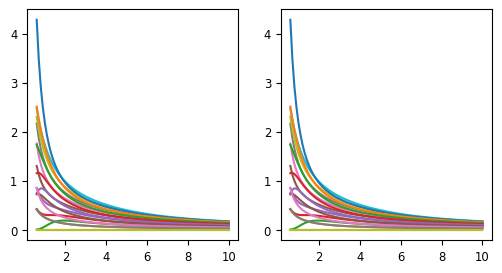

In [190]:
fig = PyPlot.figure(figsize=(6, 3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for charge in sort(collect(keys(out)))
    susceptibility = out[charge]
    ax1.plot(susceptibility[1,15:end], susceptibility[2,15:end], label="$charge")
    ax2.plot(susceptibility[1,15:end], susceptibility[3,15:end], label="$charge")
end
# PyPlot.legend()

In [191]:
# Check the differences
for charge in sort(collect(keys(out)))
    susceptibility = out[charge]
    if maximum(abs2.(susceptibility[2, :] - susceptibility[3,:])) > 1E-8
        @show charge
    end
end

In [192]:
# PyPlot.figure(figsize=(3.5, 3))
# for charge in [5, 6,7,8,9,10,11,12, 13]
#     susceptibility = out[charge]
#     PyPlot.plot(susceptibility[1,5:end], 1 ./ susceptibility[2,5:end], label="$charge")
# end
# PyPlot.legend()
# PyPlot.xlim(0, 5)
# PyPlot.ylim(0, 5)

In [193]:
select_charges = charges[0.5 .<= (charges ./ n_sites) .<= 1.5];
select_charge_lookup = Dict(v => k for (k, v) in enumerate(select_charges))
ncols = Int(ceil(sqrt(length(select_charges))))
nrows = Int(ceil(length(select_charges) / ncols))
println(length(select_charges), ", ", nrows, ", ", ncols)

select_temperatures = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
select_temperature_lookup = Dict(v => i for (i, v) in enumerate(select_temperatures))
nrows_T, ncols_T = 3, 3
;

9, 3, 3


# Canonical Ensemble

In [194]:
canonical_df = let
    Qs = Int[]
    Ts = Float64[]
    χ0s = Float64[]
    χΓs = Float64[]
    χΣs = Float64[]
    χKs = Float64[]
    Cvs = Float64[]
    for sdf in groupby(df, [:charge, :temperature])
        Q = first(sdf.charge)
        T = first(sdf.temperature)
        
        E0 = minimum(sdf.base_energy)
        boltzmann = exp.(-(sdf.base_energy .- E0) ./ T)        
        Z = sum(boltzmann .* sdf.partition)
        push!(Qs, Q)
        push!(Ts, T)
        push!(χ0s, sum(sdf.Sz2 .* boltzmann .* sdf.partition) / Z / T)
        push!(χΓs, sum(sdf.SzSz_Γ .* boltzmann) / Z / T)
        push!(χΣs, sum(sdf.SzSz_Σ .* boltzmann) / Z / T)
        push!(χKs, sum(sdf.SzSz_K .* boltzmann) / Z / T)
        let
            corr = sum(
                (sdf.energy_squared
                    + 2 .* sdf.base_energy .* sdf.energy
                    + (sdf.base_energy.^ 2) .* sdf.partition) .* boltzmann    
            ) / Z
            avg = sum((sdf.energy .+ sdf.base_energy .* sdf.partition) .* boltzmann) / Z
            push!(Cvs, (corr - avg^2) / (n_sites * T))
        end
    end
    DataFrame(
        "charge" => Qs,
        "temperature" => Ts,
        "specific_heat" => Cvs,
        "susceptibilities_0" => χ0s,
        "susceptibilities_Γ" => χΓs,
        "susceptibilities_Σ" => χΣs,
        "susceptibilities_K" => χKs,
    )
end

sort!(canonical_df, [:charge, :temperature])
;

# Grand Canonical

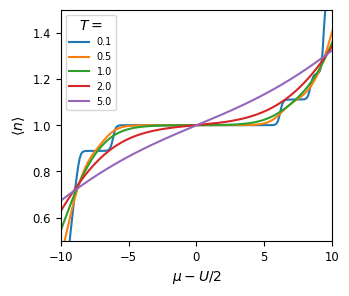

# Specific Heat

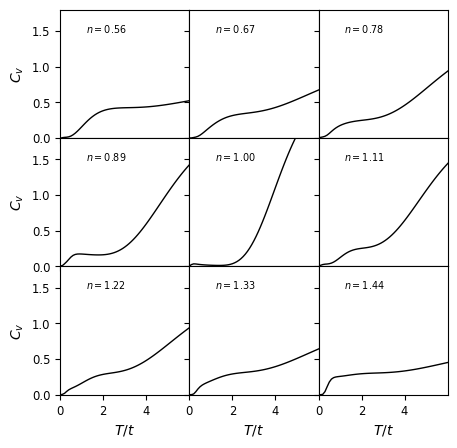

In [27]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, :temperature)
    
    ax.plot(sdf.temperature, sdf.specific_heat, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )    
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4])
end
axs[1,1].set_xlim(0, 6)
axs[1,1].set_ylim(0, 1.8)

fig.savefig("specific-heat_$(shape_str).pdf", dpi=300, bbox_inches="tight")

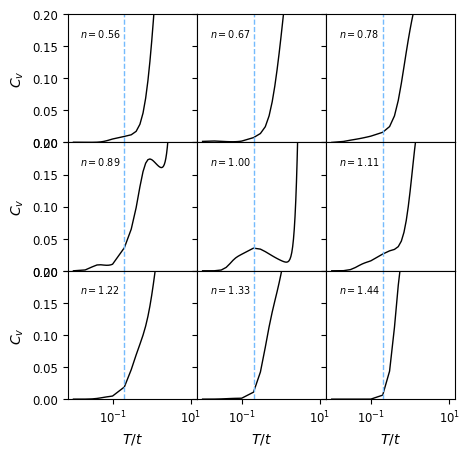

In [28]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, :temperature)
    
    ax.plot(sdf.temperature, sdf.specific_heat, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
    ax.text(
        0.1, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
    ax.axvline(4*hopping/interaction, linestyle="--", color="xkcd:sky blue", linewidth=1)
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
end
# axs[1,1].set_xlim(0, 0.5)
axs[1,1].set_xscale("log")
axs[1,1].set_ylim(0, 0.2)

fig.savefig("specific-heat-closeup_$(shape_str).pdf", dpi=300, bbox_inches="tight")

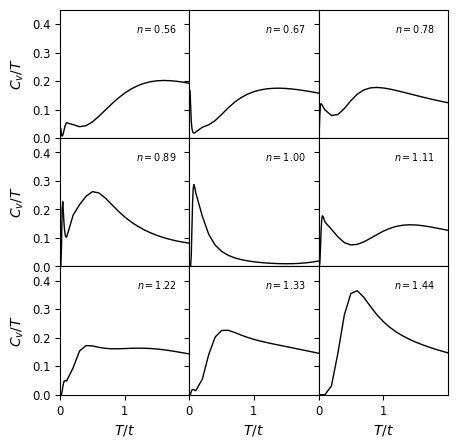

In [29]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = sdf.specific_heat ./ sdf.temperature
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.text(
        0.9, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize="x-small"
    )
#     ax.axvline(1/20, linestyle="--")
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v/T$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,1,])
end
axs[1,1].set_xlim(0, 2)
axs[1,1].set_ylim(0, 0.45)

fig.savefig("entropy_$(shape_str).pdf", dpi=300, bbox_inches="tight")

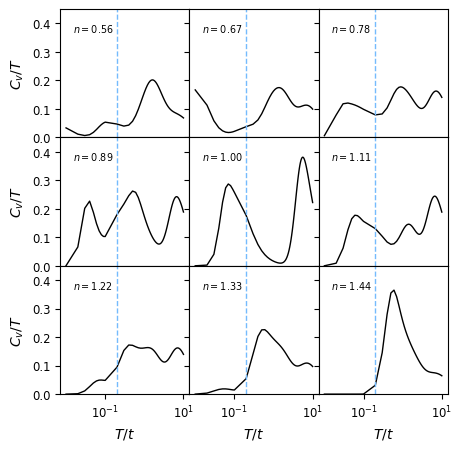

In [30]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = sdf.specific_heat ./ sdf.temperature
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.text(
        0.1, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
    ax.axvline(4*hopping/interaction, linestyle="--", linewidth=1, color="xkcd:sky blue", )
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v/T$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,1,])
end
# axs[1,1].set_xlim(0, 0.5)
axs[1,1].set_xscale("log")
axs[1,1].set_ylim(0, 0.45)

fig.savefig("entropy-log-closeup_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# Linear Fits (Curie-Weiss) (χ(Γ))

In [31]:
@. model(x, p) = (x - p[2]) / p[1]

model (generic function with 1 method)

In [32]:
temperature_range = [0.7, 5.5]

fit_df = let
    charges = Int[]
    intercepts_0, slopes_0 = Float64[], Float64[]
    intercepts_Γ, slopes_Γ = Float64[], Float64[]
    intercepts_K, slopes_K = Float64[], Float64[]
    intercepts_Σ, slopes_Σ = Float64[], Float64[]
    
    for sdf in groupby(canonical_df, :charge)
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_0) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_Γ) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_K) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_Σ) && continue
        
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_0
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(charges, first(sdf.charge))
        push!(intercepts_0, f.param[2])
        push!(slopes_0, f.param[1])
                
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_Γ
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_Γ, f.param[2])
        push!(slopes_Γ, f.param[1])

        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_K
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_K, f.param[2])
        push!(slopes_K, f.param[1])
        
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_Σ
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_Σ, f.param[2])
        push!(slopes_Σ, f.param[1])    
    end
    DataFrame("charge" => charges,
        "intercept_0" => intercepts_0, "slope_0" => slopes_0,
        "intercept_Γ" => intercepts_Γ, "slope_Γ" => slopes_Γ,
        "intercept_Σ" => intercepts_Σ, "slope_Σ" => slopes_Σ,
        "intercept_K" => intercepts_K, "slope_K" => slopes_K,
    )
end


17×9 DataFrame
 Row │ charge  intercept_0   slope_0   intercept_Γ   slope_Γ    intercept_Σ    ⋯
     │ Int64   Float64       Float64   Float64       Float64    Float64        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      1   7.75972e-17  0.25       7.75972e-17  0.25        7.75972e-17   ⋯
   2 │      2  -6.37447e7    6.1154e6  -6.37253e7    6.11354e6   0.0959133
   3 │      3  -1.81449      1.01932   -1.81449      1.01932     0.058615
   4 │      4  -0.922259     1.14697   -0.922259     1.14697     0.0310025
   5 │      5  -0.580093     1.33181   -0.580093     1.33181     0.0126225     ⋯
   6 │      6  -0.392491     1.52926   -0.392491     1.52926     0.00310637
   7 │      7  -0.279503     1.73056   -0.279503     1.73056     0.00621432
   8 │      8  -0.218543     1.93146   -0.218543     1.93146     0.0343429
   9 │      9  -0.123707     2.07424   -0.123707     2.07424     0.137522      ⋯
  10 │     10   0.142117     1.80675    0.142117     1.80675     0.0709981
  11 │     11   0.032875     1.65842    0.032875     1.65842     0.072525
  12 │     12  -0.0653643    1.47362   -0.0653643    1.47362     0.0740397
  13 │     13  -0.151404     1.26414   -0.151404     1.26414     0.0754089     ⋯
  14 │     14  -0.206979     1.03172   -0.206979     1.03172     0.0733271
  15 │     15  -0.151397     0.768384  -0.151397     0.768384    0.0587974
  16 │     16  -0.0297828    0.500493  -0.0297828    0.500493    0.0288699
  17 │     17   7.75972e-17  0.25      -9.82086e-17  0.25       -1.00666e-16   ⋯
                                                               3 columns omitted

In [33]:
names(canonical_df)

7-element Vector{String}:
 "charge"
 "temperature"
 "specific_heat"
 "susceptibilities_0"
 "susceptibilities_Γ"
 "susceptibilities_Σ"
 "susceptibilities_K"

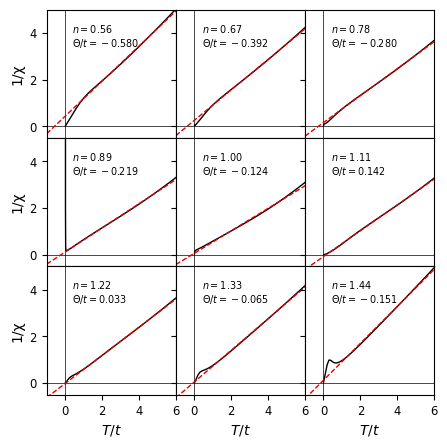

In [34]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = 1.0 ./ sdf.susceptibilities_0
    # @show ax
    # @show xs
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
end

for row in eachrow(fit_df)
    charge = row.charge
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]    
    xs_fit = [-1, 10]
    ys_fit = model(xs_fit, [row.slope_0, row.intercept_0])
    
    ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" charge/n_sites row.intercept_0),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
end

for i in 1:nrows
    axs[i, 1].set_ylabel("1/χ")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4,6])
end
axs[1,1].set_xlim(-1, 6)
axs[1,1].set_ylim(-0.5, 5)

fig.savefig("curie-weiss_$(shape_str).pdf", dpi=300, bbox_inches="tight")

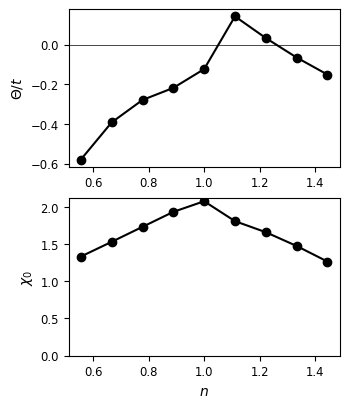

In [35]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_0, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_0, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")

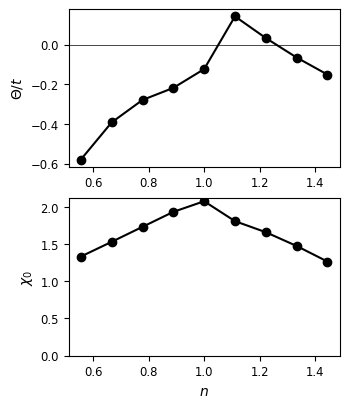

In [36]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_Γ, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_Γ, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit-GM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

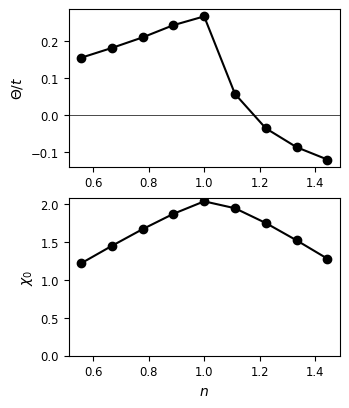

In [37]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_K, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_K, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit-K_$(shape_str).pdf", dpi=300, bbox_inches="tight")

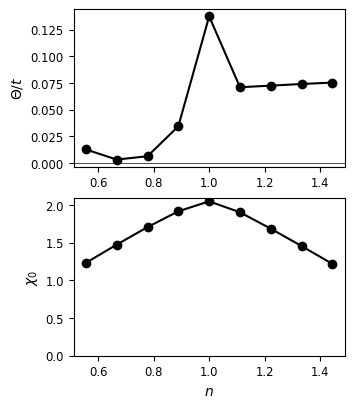

In [38]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_Σ, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_Σ, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit-SM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

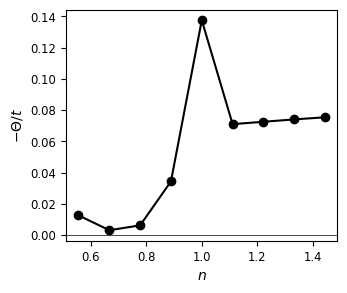

PyObject Text(24.999999999999993, 0.5, '$-\\Theta/t$')

In [39]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()

let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
    ax.plot(sdf.charge ./ n_sites, sdf.intercept_Σ, marker="o", linestyle="-", color="black")
end
ax.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\Theta/t$")
# fig.savefig("weiss-temperature_$(shape_str).pdf", dpi=300, bbox_inches="tight")

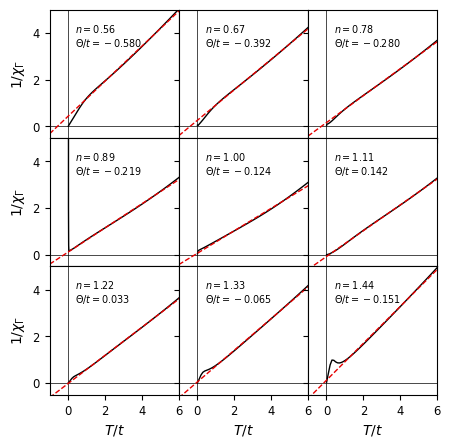

In [72]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = 1.0 ./ sdf.susceptibilities_Γ
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
end

for row in eachrow(fit_df)
    charge = row.charge
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]    
    xs_fit = [-1, 10]
    ys_fit = model(xs_fit, [row.slope_Γ, row.intercept_Γ])
    
    ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" charge/n_sites row.intercept_Γ),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
end


for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$1/\chi_{\Gamma}$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4,6])
end
axs[1,1].set_xlim(-1, 6)
axs[1,1].set_ylim(-0.5, 5)

fig.savefig("susceptibility-GM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# χ(K)

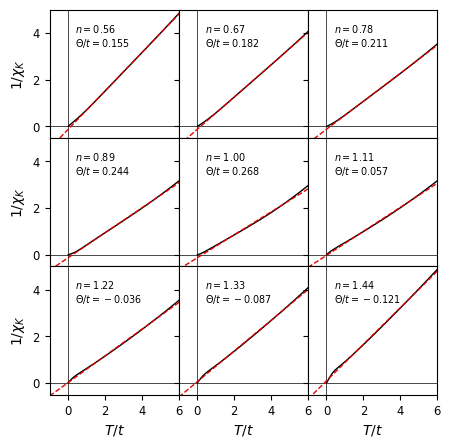

In [73]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = 1.0 ./ sdf.susceptibilities_K
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
end

for row in eachrow(fit_df)
    charge = row.charge
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]    
    xs_fit = [-1, 10]
    ys_fit = model(xs_fit, [row.slope_K, row.intercept_K])
    
    ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" charge/n_sites row.intercept_K),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$1/\chi_{K}$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4,6])
end
axs[1,1].set_xlim(-1, 6)
axs[1,1].set_ylim(-0.5, 5)

fig.savefig("susceptibility-K_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# χ(Σ)

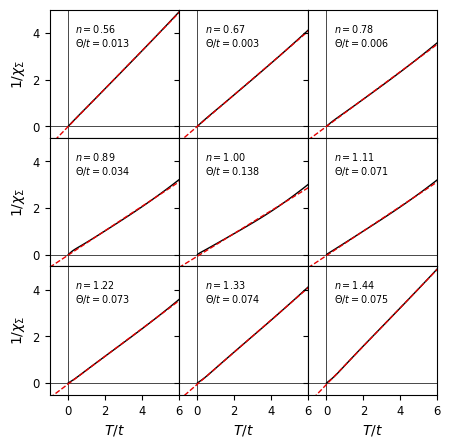

In [74]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = 1.0 ./ sdf.susceptibilities_Σ
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
end

for row in eachrow(fit_df)
    charge = row.charge
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]    
    xs_fit = [-1, 10]
    ys_fit = model(xs_fit, [row.slope_Σ, row.intercept_Σ])
    
    ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" charge/n_sites row.intercept_Σ),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$1/\chi_{\Sigma}$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4,6])
end
axs[1,1].set_xlim(-1, 6)
axs[1,1].set_ylim(-0.5, 5)

fig.savefig("susceptibility-SM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# S(q)

In [43]:
structure_factor_df = let
    Qs = Float64[]
    Ts = Float64[]
    Sqs = Vector{Float64}[]
    
    for sdf in groupby(df, [:charge, :temperature])
        T = first(sdf.temperature)
        Q = first(sdf.charge)
        Sq = zeros(Float64, length(sdf[1, :Sq]))
        Z = 0.0
        for row in eachrow(sdf)
            Sq += row.Sq
            Z += row.partition
        end
        Sq ./= Z
        push!(Qs, Q)
        push!(Ts, T)
        push!(Sqs, real.(Sq))
    end
    DataFrame("charge" => Qs, "temperature" => Ts, "structure_factor" => Sqs)
end
;

In [85]:
k0 = momentums .* 2π
G = reciprocallatticevectors
function plot_Sq(Sq::AbstractVector{<:Real}, ax::PyObject; inverse::Bool=false)
    k = Matrix{Float64}(undef, (2, 0))
    v = Vector{Float64}(undef, 0)
    if inverse
        Sq = -1 ./ Sq
    end
    for R1 in [-1,0,1], R2 in [-1,0,1]
        R = [R1; R2]
        k = hcat(k, broadcast(+, k0, G * R))
        v = vcat(v, Sq)
    end
    if inverse
        minv = minimum(filter(!isnan, v) )
        maxv = maximum(filter(!isnan, v) )
        c = mpl.cm.viridis((v .- minv) ./ (maxv - minv))
    else
        minv = minimum(filter(!isnan, v) )
        maxv = maximum(filter(!isnan, v) )
        c = mpl.cm.viridis(v ./ maxv)
    end
    img = ax.scatter(k[1,:], k[2,:], s=500, c=c, marker="H")
    ax.plot(zone_boundary[1,:], zone_boundary[2,:], color="red")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xticks([])
    ax.set_yticks([])
    return img
end

plot_Sq (generic function with 2 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


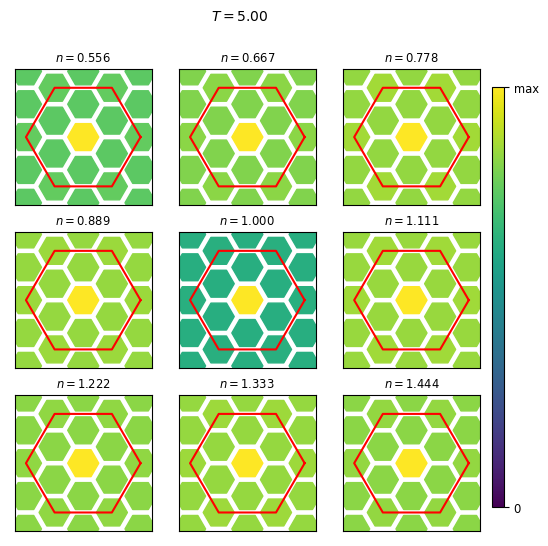

In [87]:
fig = PyPlot.figure(figsize=(6,6))

pdf = backend_pdf.PdfPages("static-structure-factor_$(shape_str).pdf")
@showprogress for T in select_temperatures
    fig.clf()
    axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    
    let sdf = filter(x -> x.temperature == T, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            charge = row.charge
            haskey(select_charge_lookup, charge) || continue            
            iq = select_charge_lookup[charge]
            Sq = copy(row.structure_factor)
            ax = axs_transpose[iq]
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="small")
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$T=%.2f\$" T), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "Shape = $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


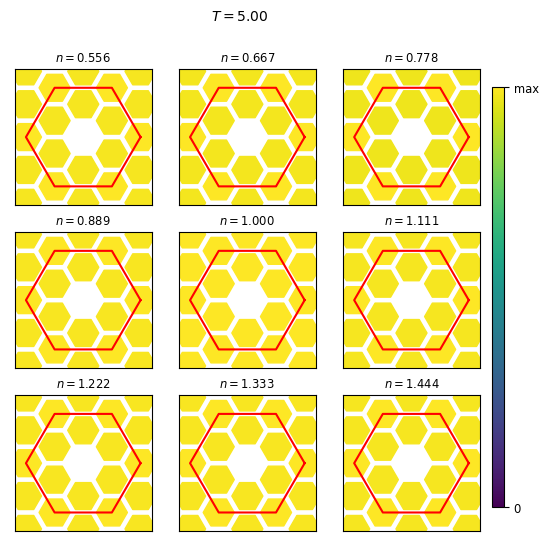

In [66]:
k0 = momentums .* 2π
G = reciprocallatticevectors

fig = PyPlot.figure(figsize=(6,6))

pdf = backend_pdf.PdfPages("static-structure-factor-no-GM_$(shape_str).pdf")
@showprogress for T in select_temperatures
    fig.clf()
    axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    
    let sdf = filter(x -> x.temperature == T, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            charge = row.charge
            haskey(select_charge_lookup, charge) || continue            
            iq = select_charge_lookup[charge]
            ax = axs_transpose[iq]
            Sq = copy(row.structure_factor)
            Sq[1] = NaN
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="small")
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$T=%.2f\$" T), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "shape: $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

## S(q) Charge per page

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


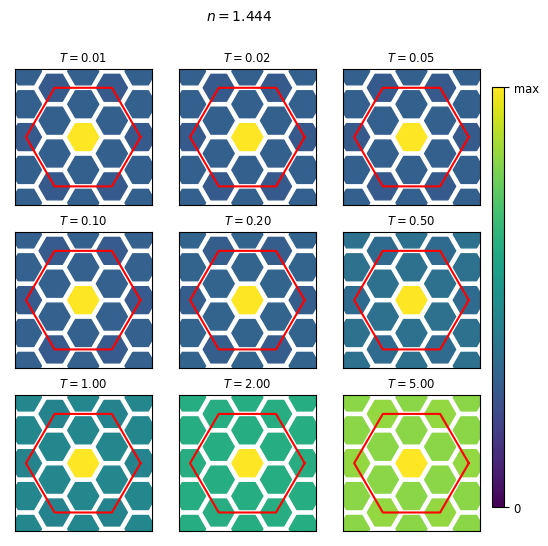

In [67]:
fig = PyPlot.figure(figsize=(6,6))
pdf = backend_pdf.PdfPages("static-structure-factor-charge-per-page_$(shape_str).pdf")
@showprogress for charge in select_charges
    fig.clf()
    axs = fig.subplots(nrows_T, ncols_T, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    let sdf = filter(x -> x.charge == charge, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            temperature = row.temperature
            haskey(select_temperature_lookup, temperature) || continue
            iT = select_temperature_lookup[temperature]
            ax = axs_transpose[iT]
            Sq = copy(row.structure_factor)
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$T=%.2f\$" temperature), fontsize="small")
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "shape: $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


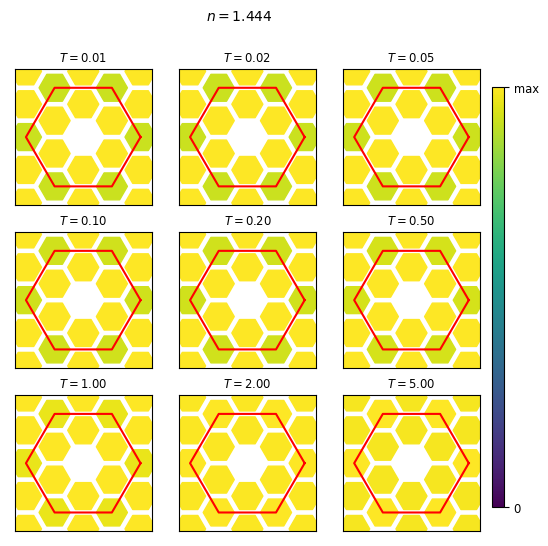

In [68]:
fig = PyPlot.figure(figsize=(6,6))
pdf = backend_pdf.PdfPages("static-structure-factor-no-GM-charge-per-page_$(shape_str).pdf")
@showprogress for charge in select_charges
    fig.clf()
    axs = fig.subplots(nrows_T, ncols_T, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    let sdf = filter(x -> x.charge == charge, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            temperature = row.temperature
            haskey(select_temperature_lookup, temperature) || continue
            iT = select_temperature_lookup[temperature]
            ax = axs_transpose[iT]
            Sq = copy(row.structure_factor)
            Sq[1] = NaN
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$T=%.2f\$" temperature), fontsize="small")
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "shape: $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

# Grand Canonical

In [201]:
@. model(x, p) = (x - p[2]) / p[1]

model (generic function with 1 method)

In [202]:
grand_canonical_df = let
    chemical_potential_list = -10:0.1:25
    chemical_potentials = Float64[]
    temperatures = Float64[]
    densities = Float64[]
    χ0s = Float64[]
    χΓs = Float64[]
    χΣs = Float64[]
    χKs = Float64[]
    Cvs = Float64[]

    for sdf in groupby(df, :temperature)
        for μ in chemical_potential_list
            T = first(sdf.temperature)
            E0 = minimum(sdf.base_energy .- μ .* sdf.charge)
            boltzmann = exp.(-(sdf.base_energy .- μ .* sdf.charge .- E0 ) ./ T)
            
            Z = sum(boltzmann .* sdf.partition)
            push!(chemical_potentials, μ)
            push!(temperatures, T)
            push!(densities, sum(sdf.charge .* boltzmann .* sdf.partition) / sum(boltzmann .* sdf.partition) / n_sites)
            
            push!(χ0s, sum(sdf.Sz2 .* boltzmann .* sdf.partition) / Z / T)
            push!(χΓs, sum(sdf.SzSz_Γ .* boltzmann) / Z / T)
            push!(χΣs, sum(sdf.SzSz_Σ .* boltzmann) / Z / T)
            push!(χKs, sum(sdf.SzSz_K .* boltzmann) / Z / T)
            let
                corr = sum(
                    (sdf.energy_squared
                        + 2 .* sdf.base_energy .* sdf.energy
                        + (sdf.base_energy.^ 2) .* sdf.partition) .* boltzmann    
                ) / Z
                avg = sum((sdf.energy .+ sdf.base_energy .* sdf.partition) .* boltzmann) / Z
                push!(Cvs, (corr - avg^2) / (n_sites * T))
            end
            
            
        end
    end
    DataFrame(
        "chemical_potential" => chemical_potentials,
        "temperature" => temperatures,
        "density" => densities,
        
        "specific_heat" => Cvs,
        "susceptibilities_0" => χ0s,
        "susceptibilities_Γ" => χΓs,
        "susceptibilities_Σ" => χΣs,
        "susceptibilities_K" => χKs,        
    )
end
sort!(grand_canonical_df, [:chemical_potential, :temperature])
;


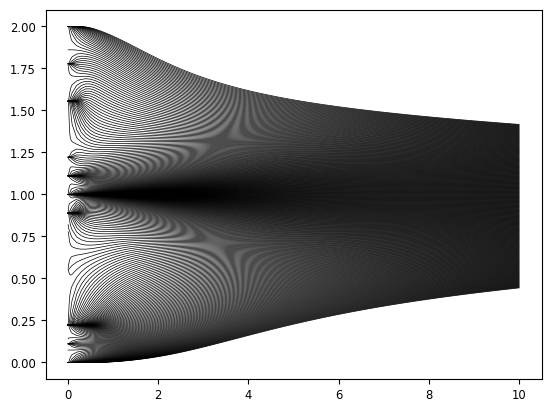

In [210]:
for sdf in groupby(grand_canonical_df, :chemical_potential)
    PyPlot.plot(sdf.temperature, sdf.density, "k-", linewidth=0.5)
end

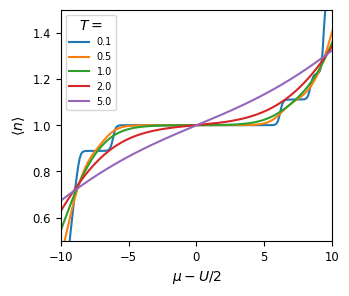

In [203]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
for sdf in groupby(grand_canonical_df, :temperature)
    T = first(sdf.temperature)
    T ∈ [0.1, 0.5, 1.0, 2.0, 5.0] || continue
    ax.plot(sdf.chemical_potential .- interaction / 2, sdf.density, alpha=1, label= (@sprintf "%.1f" T)    )
end
ax.set_xlim(-20, 15)
ax.set_ylim(0, 2.1)

ax.set_xlim(-10,10)
ax.set_ylim(0.5, 1.5)

ax.legend(title="\$T=\$", fontsize="x-small")
ax.set_xlabel(raw"$\mu - U/2$")
ax.set_ylabel(raw"$\langle n \rangle$")
fig.savefig("density-vs-chemical-potential_$shape_str.pdf", dpi=300, bbox_inches="tight")

In [222]:
function foo!(F, x)
    F[1] = x[1] - 2.771
end

foo! (generic function with 1 method)

In [223]:
y = nlsolve(foo!, [1.0], autodiff=:forward)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0]
 * Zero: [2.771]
 * Inf-norm of residuals: 0.000000
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 3
 * Jacobian Calls (df/dx): 3

In [214]:
using NLsolve

In [323]:
target_densities = 0.5:0.05:1.5

grand_canonical_df = let
    ρs = Float64[]
    converged_ρs = Float64[]
    μs = Float64[]
    Ts = Float64[]
    χ0s = Float64[]
    χΓs = Float64[]
    χΣs = Float64[]
    χKs = Float64[]
    Cvs = Float64[]

    for sdf in groupby(df, :temperature)
        T = first(sdf.temperature)    
        for ρ in target_densities
            μ = NaN
            for trial in 1:10
                function f!(F, x)
                    μ = x[1]
                    E0 = minimum(sdf.base_energy .- μ .* sdf.charge)
                    boltzmann = exp.(-(sdf.base_energy .- μ .* sdf.charge .- E0 ) ./ T)
                    Z = sum(boltzmann .* sdf.partition)
                    F[1] = sum(sdf.charge .* boltzmann .* sdf.partition) / Z / n_sites - ρ
                end
                y = nlsolve(f!, [5*rand()]; autodiff=:forward, iterations=20000)
                μ = y.zero[1]
                if converged(y)
                    break
                end
            end

            T = first(sdf.temperature)
            E0 = minimum(sdf.base_energy .- μ .* sdf.charge)
            boltzmann = exp.(-(sdf.base_energy .- μ .* sdf.charge .- E0 ) ./ T)

            Z = sum(boltzmann .* sdf.partition)
            
            push!(ρs, ρ)
            push!(Ts, T)
            push!(μs, μ)
            push!(converged_ρs, sum(sdf.charge .* boltzmann .* sdf.partition) / sum(boltzmann .* sdf.partition) / n_sites)
            push!(χ0s, sum(sdf.Sz2 .* boltzmann .* sdf.partition) / Z / T)
            push!(χΓs, sum(sdf.SzSz_Γ .* boltzmann) / Z / T)
            push!(χΣs, sum(sdf.SzSz_Σ .* boltzmann) / Z / T)
            push!(χKs, sum(sdf.SzSz_K .* boltzmann) / Z / T)
            let
                corr = sum(
                    (sdf.energy_squared
                        + 2 .* sdf.base_energy .* sdf.energy
                        + (sdf.base_energy.^ 2) .* sdf.partition) .* boltzmann    
                ) / Z
                avg = sum((sdf.energy .+ sdf.base_energy .* sdf.partition) .* boltzmann) / Z
                push!(Cvs, (corr - avg^2) / (n_sites * T))
            end
        end
    end
    DataFrame(
        "density" => ρs,
        "converged_density" => converged_ρs,
        "chemical_potential" => μs,
        "temperature" => Ts,
        "specific_heat" => Cvs,
        "susceptibilities_0" => χ0s,
        "susceptibilities_Γ" => χΓs,
        "susceptibilities_Σ" => χΣs,
        "susceptibilities_K" => χKs,
    )
end

2289×9 DataFrame
  Row │ density  converged_density  chemical_potential  temperature  specific_ ⋯
      │ Float64  Float64            Float64             Float64      Float64   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │    0.5                0.5             0.661948         0.01     2.1301 ⋯
    2 │    0.55               0.55            0.685825         0.01     0.2390
    3 │    0.6                0.6             0.920626         0.01     3.1106
    4 │    0.65               0.65            0.931149         0.01     4.8225
    5 │    0.7                0.7             0.940049         0.01     4.4958 ⋯
    6 │    0.75               0.75            0.952996         0.01     2.1350
    7 │    0.8                0.8             1.0907           0.01     2.0722
    8 │    0.85               0.85            1.11075          0.01     2.9464
    9 │    0.9                0.9             3.90715          0.01    15.5471 ⋯
   10 │    0.95               0.95            3.93113          0.01    42.7545
   11 │    1.0                1.0             9.88747          0.01     1.9255
  ⋮   │    ⋮             ⋮                  ⋮                ⋮             ⋮   ⋱
 2280 │    1.05               1.05           11.8753          10.0      5.4945
 2281 │    1.1                1.1            13.7281          10.0      6.2721 ⋯
 2282 │    1.15               1.15           15.5607          10.0      7.0509
 2283 │    1.2                1.2            17.3682          10.0      7.8011
 2284 │    1.25               1.25           19.1501          10.0      8.4931
 2285 │    1.3                1.3            20.9104          10.0      9.0996 ⋯
 2286 │    1.35               1.35           22.6569          10.0      9.5968
 2287 │    1.4                1.4            24.4006          10.0      9.9644
 2288 │    1.45               1.45           26.1558          10.0     10.1851
 2289 │    1.5                1.5            27.9402          10.0     10.2448 ⋯
                                                 5 columns and 2268 rows omitted

In [324]:
filter!(row -> row.temperature >= 0.02, grand_canonical_df);

In [325]:
grand_canonical_df

2268×9 DataFrame
  Row │ density  converged_density  chemical_potential  temperature  specific_ ⋯
      │ Float64  Float64            Float64             Float64      Float64   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │    0.5                0.5             0.664837         0.02     1.0270 ⋯
    2 │    0.55               0.55            0.713651         0.02     0.1193
    3 │    0.6                0.6             0.914133         0.02     1.5600
    4 │    0.65               0.65            0.935518         0.02     2.3804
    5 │    0.7                0.7             0.95365          0.02     2.2009 ⋯
    6 │    0.75               0.75            0.979849         0.02     1.0490
    7 │    0.8                0.8             1.10238          0.02     1.0397
    8 │    0.85               0.85            1.14241          0.02     1.4703
    9 │    0.9                0.9             3.87161          0.02     7.7675 ⋯
   10 │    0.95               0.95            3.91956          0.02    21.358
   11 │    1.0                1.0             4.24757          0.02     5.4077
  ⋮   │    ⋮             ⋮                  ⋮                ⋮             ⋮   ⋱
 2259 │    1.05               1.05           11.8753          10.0      5.4945
 2260 │    1.1                1.1            13.7281          10.0      6.2721 ⋯
 2261 │    1.15               1.15           15.5607          10.0      7.0509
 2262 │    1.2                1.2            17.3682          10.0      7.8011
 2263 │    1.25               1.25           19.1501          10.0      8.4931
 2264 │    1.3                1.3            20.9104          10.0      9.0996 ⋯
 2265 │    1.35               1.35           22.6569          10.0      9.5968
 2266 │    1.4                1.4            24.4006          10.0      9.9644
 2267 │    1.45               1.45           26.1558          10.0     10.1851
 2268 │    1.5                1.5            27.9402          10.0     10.2448 ⋯
                                                 5 columns and 2247 rows omitted

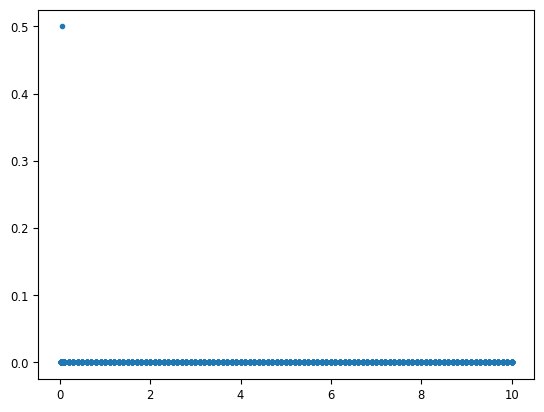

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x155322a7f040>

In [326]:
PyPlot.plot(grand_canonical_df.temperature, grand_canonical_df.density - grand_canonical_df.converged_density, ".")

In [327]:
filter(row -> !isapprox(row.density, row.converged_density; atol=1E-4, rtol=1E-4), grand_canonical_df)

1×9 DataFrame
 Row │ density  converged_density  chemical_potential  temperature  specific_h ⋯
     │ Float64  Float64            Float64             Float64      Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1.5                1.0             5.43203         0.04     0.00526 ⋯
                                                               5 columns omitted

In [328]:
temperature_range = [0.7, 5.5]

grand_canonical_fit_df = let
    densities = Float64[]
    intercepts_0, slopes_0 = Float64[], Float64[]
    intercepts_Γ, slopes_Γ = Float64[], Float64[]
    intercepts_K, slopes_K = Float64[], Float64[]
    intercepts_Σ, slopes_Σ = Float64[], Float64[]
    
    for sdf in groupby(grand_canonical_df, :density)
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_0) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_Γ) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_K) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_Σ) && continue
        
        push!(densities, first(sdf.density))
                
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_0
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_0, f.param[2])
        push!(slopes_0, f.param[1])
                
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_Γ
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_Γ, f.param[2])
        push!(slopes_Γ, f.param[1])

        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_K
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_K, f.param[2])
        push!(slopes_K, f.param[1])
        
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_Σ
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_Σ, f.param[2])
        push!(slopes_Σ, f.param[1])    
    end
    DataFrame("density" => densities,
        "intercept_0" => intercepts_0, "slope_0" => slopes_0,
        "intercept_Γ" => intercepts_Γ, "slope_Γ" => slopes_Γ,
        "intercept_Σ" => intercepts_Σ, "slope_Σ" => slopes_Σ,
        "intercept_K" => intercepts_K, "slope_K" => slopes_K,
    )
end


21×9 DataFrame
 Row │ density  intercept_0  slope_0  intercept_Γ  slope_Γ  intercept_Σ  slope ⋯
     │ Float64  Float64      Float64  Float64      Float64  Float64      Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    0.5   -0.679658    1.22455  -0.679658    1.22455    0.0258908  1.103 ⋯
   2 │    0.55  -0.565739    1.31212  -0.565739    1.31212    0.0213446  1.212
   3 │    0.6   -0.476404    1.40089  -0.476404    1.40089    0.0191191  1.319
   4 │    0.65  -0.404153    1.4899   -0.404153    1.4899     0.0196941  1.424
   5 │    0.7   -0.344012    1.5782   -0.344012    1.5782     0.0238409  1.527 ⋯
   6 │    0.75  -0.292103    1.66448  -0.292103    1.66448    0.032802   1.625
   7 │    0.8   -0.244625    1.74663  -0.244625    1.74663    0.0485895  1.716
   8 │    0.85  -0.196822    1.82086  -0.196822    1.82086    0.0744369  1.795
   9 │    0.9   -0.141908    1.88023  -0.141908    1.88023    0.115182   1.857 ⋯
  10 │    0.95  -0.071372    1.91305  -0.071372    1.91305    0.176043   1.890
  11 │    1.0    0.0112259   1.90651   0.0112259   1.90651    0.24641    1.883
  12 │    1.05   0.0782529   1.85803   0.0782529   1.85803    0.188782   1.885
  13 │    1.1    0.106438    1.79492   0.106438    1.79492    0.140936   1.848 ⋯
  14 │    1.15   0.10127     1.72805   0.10127     1.72805    0.112798   1.783
  15 │    1.2    0.0749664   1.65823   0.0749664   1.65823    0.0973992  1.700
  16 │    1.25   0.0402056   1.58323   0.0402056   1.58323    0.0888854  1.607
  17 │    1.3    0.00284445  1.50261   0.00284445  1.50261    0.0840292  1.509 ⋯
  18 │    1.35  -0.0342247   1.41659  -0.0342247   1.41659    0.0811009  1.408
  19 │    1.4   -0.06914     1.32546  -0.06914     1.32546    0.0791005  1.304
  20 │    1.45  -0.100075    1.22944  -0.100075    1.22944    0.0773649  1.199
  21 │    1.5   -0.124688    1.12857  -0.124688    1.12857    0.0753796  1.093 ⋯
                                                               3 columns omitted

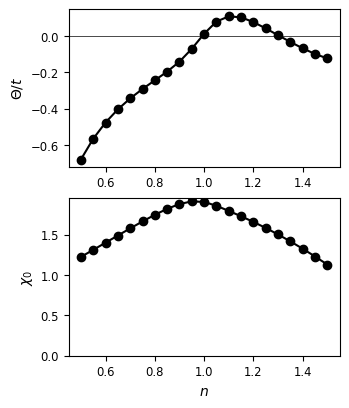

PyObject Text(0.5, 24.0, '$n$')

In [329]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> 0.5 <= x.density <= 1.5, grand_canonical_fit_df)
    ax1.plot(sdf.density, sdf.intercept_0, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.density, sdf.slope_0, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
# fig.savefig("curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")

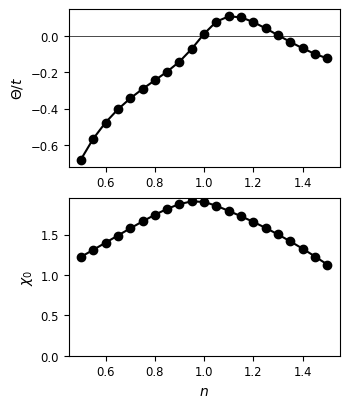

PyObject Text(0.5, 24.0, '$n$')

In [330]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> 0.5 <= x.density <= 1.5, grand_canonical_fit_df)
    ax1.plot(sdf.density, sdf.intercept_Γ, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.density, sdf.slope_Γ, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
# fig.savefig("curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")

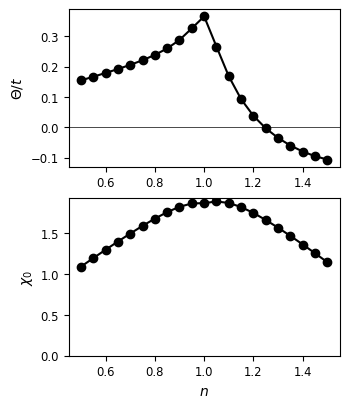

PyObject Text(0.5, 24.0, '$n$')

In [331]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> 0.5 <= x.density <= 1.5, grand_canonical_fit_df)
    ax1.plot(sdf.density, sdf.intercept_K, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.density, sdf.slope_K, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
# fig.savefig("curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")

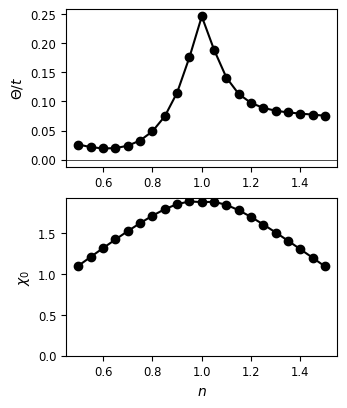

PyObject Text(0.5, 24.0, '$n$')

In [332]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> 0.5 <= x.density <= 1.5, grand_canonical_fit_df)
    ax1.plot(sdf.density, sdf.intercept_Σ, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.density, sdf.slope_Σ, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
# fig.savefig("curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# ----------- Cut Here -----------------

In [49]:
# results = []
# for T in temperatures
#     idx = df[!, :temperature] .== T
#     Z = sum(df[idx, :partition])
#     ks = [sum(df[idx, :partition] .* kmaps[i, idx]) / Z for i in 1:n_sites]
#     push!(results, (T => ks))
# end

In [50]:
# kmap_T_dependence = [hcat([[T, real(V[i])] for (T, V) in results]...) for i in 1:size(momentums,2)]

In [51]:
# for i in [1,2,5]
#     Ts = kmap_T_dependence[i][1,:]
#     Sqs = kmap_T_dependence[i][2,:]
#     χs = Sqs ./ Ts
#     PyPlot.plot(Ts, 1.0 ./ χs, "-", label="$i")
# end
# PyPlot.legend()
# PyPlot.ylim()

In [52]:
# k1 = hcat([[T, V[1]] for (T, V) in results]...)

In [53]:
# select_temperatures = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0];

In [54]:
# select_indices = [findfirst(==(y), temperatures) for y in select_temperatures]

In [55]:
# fig = PyPlot.figure(figsize=(3.5, 7))
# maxval = 0.0
# ax = nothing
# img = nothing


# for i in 1:8
#     j = select_indices[i]
#     T, Sq = results[j]
#     ax = fig.add_subplot(4,2,i)
#     k0 = momentums .* 2π
#     G = reciprocallatticevectors
#     v0 = abs2.(Sq)
#     k = Matrix{Float64}(undef, (2,0))
#     v = Vector{Float64}(undef, 0)
#     for R1 in [-1,0,1], R2 in [-1,0,1]
#         R = [R1;R2]
#         k = hcat(k, broadcast(+, k0, G * R))
#         v = vcat(v, v0)
#     end
#     img = ax.scatter(k[1,:], k[2,:], s=300, c=mpl.cm.viridis(v ./ maximum(v)), marker="H")
#     ax.plot(zone_boundary[1,:], zone_boundary[2,:], color="red")
#     ax.set_xlim(-5,5)
#     ax.set_ylim(-5,5)
#     ax.set_aspect(1.0)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_title("T=$(T)")
# end
# cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
# cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
# # cbar_ax.set_yticks([0, 1])
# cbar_ax.set_yticklabels(["0", "max"])

LoadError: UndefVarError: select_indices not defined

In [56]:
# reciprocallattice = hcat((reciprocallatticevectors * [R1, R2]  for R1 in [-1,0,1] for R2 in [-1,0,1])...)

2×9 Matrix{Float64}:
  -6.28319  -6.28319  -6.28319  …  0.0      6.28319  6.28319   6.28319
 -10.8828   -3.6276    3.6276      7.2552  -3.6276   3.6276   10.8828

In [57]:
# sp = pyimport("scipy")
# pyimport("scipy.spatial")

PyObject <module 'scipy.spatial' from '/gpfs/home/kyungminlee_42/.conda/envs/conda_jl/lib/python3.9/site-packages/scipy/spatial/__init__.py'>

In [58]:
# voro = sp.spatial.Voronoi(reciprocallattice')

PyObject <scipy.spatial.qhull.Voronoi object at 0x14a22d911820>

In [59]:
# p0 = [4π/3, 0]
# R = [cos(π/3) -sin(π/3); sin(π/3) cos(π/3)]
# zone_boundary = [p0]
# p = p0
# for i in 1:5
#     p = R * p
#     push!(zone_boundary, p)
# end
# push!(zone_boundary, p0)
# zone_boundary = hcat(zone_boundary...)

2×7 Matrix{Float64}:
 4.18879  2.0944  -2.0944  -4.18879      -2.0944   2.0944  4.18879
 0.0      3.6276   3.6276   1.51297e-15  -3.6276  -3.6276  0.0

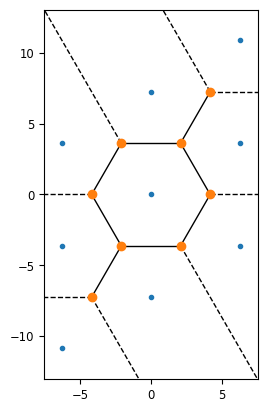

In [60]:

# sp.spatial.voronoi_plot_2d(voro)
# ax = PyPlot.gca()
# # ax.plot([0,4π/3], [0,0])
# ax.set_aspect(1.0)

In [61]:
# voro.regions
# voro.ridge_points
# voro.vertices

10-element Vector{Vector}:
 Any[]
 [1, 0, -1]
 [4, -1, 2, 3]
 [4, -1]
 [4, -1, 0, 3]
 [7, -1, 5, 6]
 [-1, 2, 5]
 [6, 1, 0, 3, 2, 5]
 [7, -1]
 [7, -1, 1, 6]

16×2 Matrix{Int32}:
 6  3
 6  4
 6  7
 1  2
 1  4
 1  0
 1  3
 0  3
 3  4
 5  2
 5  4
 5  8
 5  7
 2  4
 4  7
 8  7

8×2 Matrix{Float64}:
  2.0944   -3.6276
  4.18879   0.0
 -4.18879   0.0
 -2.0944   -3.6276
 -4.18879  -7.2552
 -2.0944    3.6276
  2.0944    3.6276
  4.18879   7.2552